In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Activation
from keras import regularizers
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import tensorflow as tf

In [3]:
csvFilePath = 'hcl_combined.csv'
df = pd.read_csv(csvFilePath)

In [4]:
def createDataset(dataset, target, lookBack=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - lookBack):
        a = dataset[i:(i + lookBack), :]
        dataX.append(a)
        dataY.append(target[i + lookBack])
    return np.array(dataX), np.array(dataY)
#enddef

In [ ]:
features = df.drop(['Date', 'Close Price'], axis=1).values
target = df['Close Price'].values

scalerFeatures = MinMaxScaler(feature_range=(0, 1))
scalerTarget = MinMaxScaler(feature_range=(0, 1))

featuresScaled = scalerFeatures.fit_transform(features)
targetScaled = scalerTarget.fit_transform(target.reshape(-1, 1))

lookBack = 8
X, y = createDataset(featuresScaled, targetScaled, lookBack)
print(X[:2])
print(y[:2])

trainSize = int(len(X) * 0.8)
testSize = len(X) - trainSize
trainX, testX = X[0:trainSize, :], X[trainSize:len(X), :]
trainY, testY = y[0:trainSize], y[trainSize:len(y)]

trainX = np.reshape(trainX, (trainX.shape[0], lookBack, trainX.shape[2]))
testX = np.reshape(testX, (testX.shape[0], lookBack, testX.shape[2]))


[[[0.77554452 0.79123672 0.79610149 0.05541109 0.56147761 0.5485922
   0.69288635 0.37524193 0.07055201]
  [0.80557891 0.81518558 0.8101021  0.02421953 0.         0.
   0.         0.         1.        ]
  [0.75093619 0.8397505  0.79648824 0.04765688 0.         0.
   0.         0.         1.        ]]

 [[0.80557891 0.81518558 0.8101021  0.02421953 0.         0.
   0.         0.         1.        ]
  [0.75093619 0.8397505  0.79648824 0.04765688 0.         0.
   0.         0.         1.        ]
  [0.78815438 0.8013245  0.75966894 0.15528482 0.74096172 0.76670818
   0.50480956 0.12715152 0.00994117]]]
[[0.80175601]
 [0.86221503]]


In [6]:
batchSize = 1
epoch = 20
neurons = 100
dropout = 0.6

model = Sequential()
model.add(LSTM(neurons, return_sequences=True, activation='tanh', input_shape=(lookBack, features.shape[1])))
model.add(Dropout(dropout))
model.add(LSTM(neurons, return_sequences=True, activation='tanh'))
model.add(Dropout(dropout))
model.add(LSTM(neurons, activation='tanh'))
model.add(Dropout(dropout))

model.add(Dense(units=1, activation='linear', activity_regularizer=regularizers.l1(0.00001)))
model.add(Activation('tanh'))
model.summary()

with tf.device('/GPU:0'):  # Forces execution on GPU
    model.compile(loss='mean_squared_error', optimizer='RMSprop')

model.fit(trainX, trainY, epochs=epoch, batch_size=batchSize, verbose=1, validation_split=0.2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 3, 100)            44000     
                                                                 
 dropout (Dropout)           (None, 3, 100)            0         
                                                                 
 lstm_1 (LSTM)               (None, 3, 100)            80400     
                                                                 
 dropout_1 (Dropout)         (None, 3, 100)            0         
                                                                 
 lstm_2 (LSTM)               (None, 100)               80400     
                                                                 
 dropout_2 (Dropout)         (None, 100)               0         
                                                                 
 dense (Dense)               (None, 1)                 1

In [7]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

trainPredictInv = scalerTarget.inverse_transform(trainPredict)
trainYInv = scalerTarget.inverse_transform(np.reshape(trainY, (trainY.shape[0], 1)))
testPredictInv = scalerTarget.inverse_transform(testPredict)
testYInv = scalerTarget.inverse_transform(np.reshape(testY, (testY.shape[0], 1)))

2/2 [==============================] - 0s 5ms/step


In [8]:
trainScore = np.sqrt(mean_squared_error(trainYInv[:, 0], trainPredictInv[:, 0]))
print(f'Training RMSE: {trainScore}')
testScore = np.sqrt(mean_squared_error(testYInv[:, 0], testPredictInv[:, 0]))
print(f'Testing RMSE: {testScore}')

trainAccuracy = 100 - (trainScore / np.mean(trainYInv) * 100)
testAccuracy = 100 - (testScore / np.mean(testYInv) * 100)

print(f'Training Accuracy: {trainAccuracy:.2f}%')
print(f'Testing Accuracy: {testAccuracy:.2f}%')

Training RMSE: 49.1956986500655
Testing RMSE: 60.10193759748134
Training Accuracy: 96.36%
Testing Accuracy: 94.51%


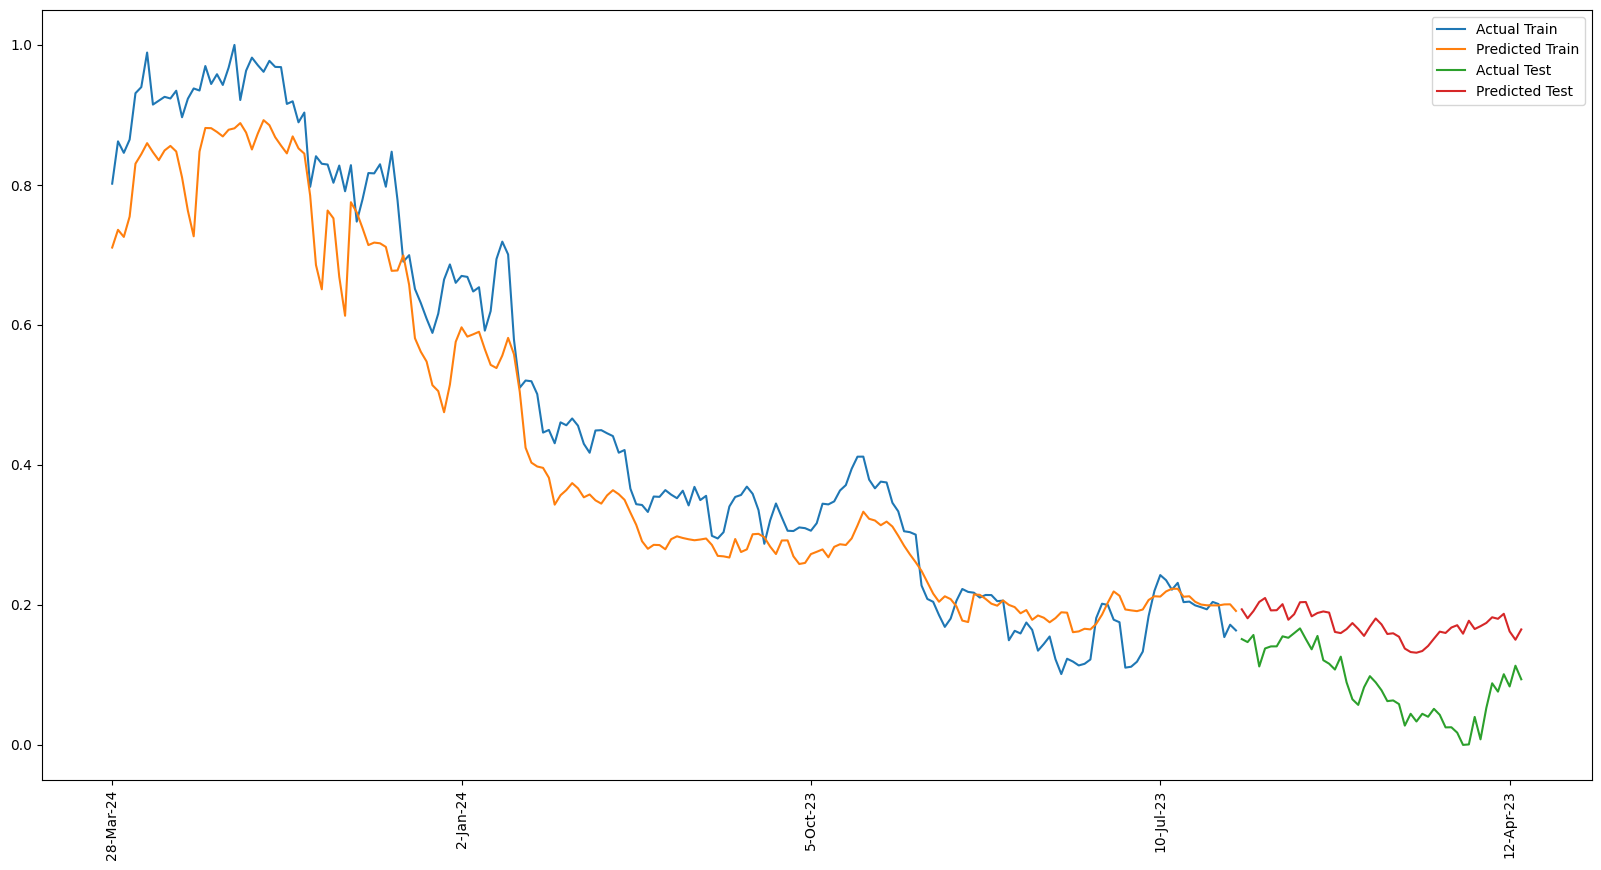

In [9]:
dates = df['Date'].values
sampleInterval = 60
sampledDates = dates[::sampleInterval]

plt.figure(figsize=(20, 10))
plt.plot(dates[:len(trainY)], trainY, label='Actual Train')
plt.plot(dates[:len(trainPredict)], trainPredict, label='Predicted Train')
plt.plot(dates[len(trainY):len(trainY) + len(testY)], testY, label='Actual Test')
plt.plot(dates[len(trainPredict):len(trainPredict) + len(testPredict)], testPredict, label='Predicted Test')

plt.xticks(sampledDates, rotation=90)

plt.legend()
plt.show()